In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

In [2]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 284807 samples in total but only 492 cases of fraud


### Feature Scaling

In [3]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[ 3.91864870e-15  5.68268579e-16 -8.76173610e-15  2.81111774e-15
 -1.55210305e-15  2.04012968e-15 -1.69895265e-15 -1.95815061e-16
 -3.14764036e-15  1.77292451e-15  9.28952385e-16 -1.80326603e-15
  1.67488824e-15  1.47562122e-15  3.50109813e-15  1.39243845e-15
 -7.46653801e-16  4.25873794e-16  9.02016885e-16  5.12684532e-16
  1.47198194e-16  8.04210901e-16  5.28245009e-16  4.45826738e-15
  1.42689564e-15  1.70163965e-15 -3.67160561e-16 -1.21815215e-16
  8.83496193e+01]
[3.83647578e+00 2.72681045e+00 2.29902117e+00 2.00467678e+00
 1.90507436e+00 1.77494002e+00 1.53039520e+00 1.42647385e+00
 1.20698823e+00 1.18558965e+00 1.04185143e+00 9.98399911e-01
 9.90567315e-01 9.18902320e-01 8.37800459e-01 7.67816427e-01
 7.21370915e-01 7.02536891e-01 6.62659610e-01 5.94323307e-01
 5.39523633e-01 5.26640906e-01 3.89949292e-01 3.66807083e-01
 2.71729873e-01 2.32542076e-01 1.62918619e-01 1.08954579e-01
 6.25598494e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

In [4]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[-2.25678488e-15 -1.71239117e-16  1.78595723e-16 -1.28963171e-15
  1.58007541e-15 -9.37326021e-17 -4.94536068e-17  5.94282165e-17
  1.06682404e-15  4.52466744e-16  2.44123467e-15  2.51412842e-15
 -9.21023919e-16 -1.01232363e-15 -1.29522625e-16 -9.85596926e-17
  1.19923593e-15  3.18853147e-16 -1.67186006e-16  4.18564063e-16
  8.94645076e-17 -3.51601875e-16 -1.16601660e-15  1.28679343e-16
 -2.51010111e-15  2.03088636e-16 -7.54884618e-18  1.28996763e-16
  2.27024770e-13]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


### Preliminary plotting

[ 1.19185711 -1.35835406 -0.96627171 -1.15823309 -0.42596588  1.22965763
 -0.64426944 -0.89428608 -0.33826175]


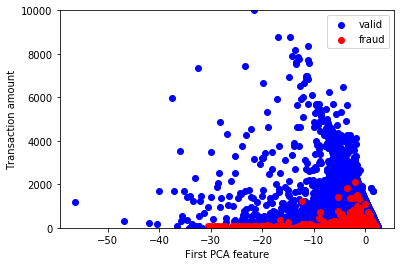

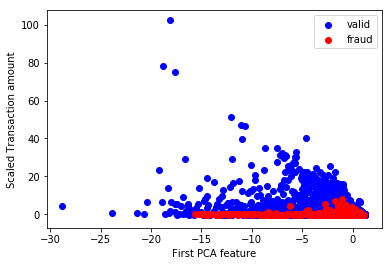

In [5]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

data_fraud_sc = data_sc[np.where(labels == 1)]
data_valid_sc = data_sc[np.where(labels == 0)]
plt.scatter(data_valid_sc[:, 0], data_valid_sc[:, -1], c='b')
plt.scatter(data_fraud_sc[:, 0], data_fraud_sc[:, -1], c='r')
# plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Scaled Transaction amount')
plt.show()

### Setting up cross-validation

In [6]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [7]:
def train_binary_SVM(data, kernel=None, class_weight=None):
    err = 0
    err_valid = 0
    err_fraud = 0
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)

        svm.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = svm.predict(data[folds[i]])
        err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        pred_valid = svm.predict(data[valid_splits[i]])
        err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        pred_fraud = svm.predict(data[fraud_splits[i]])
        err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        err += err_fold
        err_valid += err_valid_fold
        err_fraud += err_fraud_fold
    err /= 5
    err_valid /= 5
    err_fraud /= 5
    print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    return err, err_valid, err_fraud

#### Linear SVM -- Without scaling or class weights

In [8]:
train_binary_SVM(data);

Fold 0 Error: 0.0012288894350619712 Valid Error: 0.0005803422260520901 Fraud Error 0.37373737373737376
Fold 1 Error: 0.00133422281521014 Valid Error: 0.0006858589944251974 Fraud Error 0.37373737373737376
Fold 2 Error: 0.0013518021102157617 Valid Error: 0.0006331006102386437 Fraud Error 0.41836734693877553
Fold 3 Error: 0.0013518021102157617 Valid Error: 0.0008265480189226738 Fraud Error 0.30612244897959184
Fold 4 Error: 0.0012113551377258124 Valid Error: 0.0007034451224873819 Fraud Error 0.29591836734693877
FINAL Error: 0.0012956143216858896 Valid Error: 0.0006858589944251974 Fraud Error 0.3535765821480107


#### Linear SVM with Scaling

In [9]:
train_binary_SVM(data_sc);

Fold 0 Error: 0.18561497138443173 Valid Error: 0.1858677874892285 Fraud Error 0.04040404040404041
Fold 1 Error: 0.13575717144763175 Valid Error: 0.13592318379262439 Fraud Error 0.04040404040404041
Fold 2 Error: 0.1518407331331964 Valid Error: 0.1520672493537098 Fraud Error 0.02040816326530612
Fold 3 Error: 0.1818788293744843 Valid Error: 0.18217470059616975 Fraud Error 0.01020408163265306
Fold 4 Error: 0.13888449992099858 Valid Error: 0.13903592845963103 Fraud Error 0.05102040816326531
FINAL Error: 0.15879524105214857 Valid Error: 0.15901376993827268 Fraud Error 0.03248814677386106


#### Linear SVM with Scaling and Class Weights

In [10]:
train_binary_SVM(data_sc, class_weight='balanced');

Fold 0 Error: 0.4101330711702538 Valid Error: 0.41082953766069324 Fraud Error 0.010101010101010102
Fold 1 Error: 0.39199817422141076 Valid Error: 0.3926806535005188 Fraud Error 0.0
Fold 2 Error: 0.4051368480188199 Valid Error: 0.40581749116297067 Fraud Error 0.01020408163265306
Fold 3 Error: 0.4136163339829006 Valid Error: 0.41432917714506795 Fraud Error 0.0
Fold 4 Error: 0.37897859939256684 Valid Error: 0.3795965742222535 Fraud Error 0.02040816326530612
FINAL Error: 0.3999726053571904 Valid Error: 0.4006506867383008 Fraud Error 0.008142650999793857


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data_sc, kernel='rbf');

Fold 0 Error: 0.0007197780976791545 Valid Error: 5.275838418655365e-05 Fraud Error 0.3838383838383838


In [ ]:
train_binary_SVM(data_sc, kernel='rbf', class_weight='balanced');

#### Polynomial Kernel with Scaling and Class Weights

In [ ]:
train_binary_SVM(data_sc, kernel='poly');

In [ ]:
train_binary_SVM(data_sc, kernel='poly', class_weight='balanced');

In [ ]:
def train_classifier(data, kernel=None, class_weight=None):
    err = 0
    err_valid = 0
    err_fraud = 0
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)

        svm.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = svm.predict(data[folds[i]])
        err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        pred_valid = svm.predict(data[valid_splits[i]])
        err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        pred_fraud = svm.predict(data[fraud_splits[i]])
        err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        err += err_fold
        err_valid += err_valid_fold
        err_fraud += err_fraud_fold
    err /= 5
    err_valid /= 5
    err_fraud /= 5
    print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    return err, err_valid, err_fraud

### Logistic Regression

In [ ]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        pred_valid = model.predict(data[valid_splits[i]])
        err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        pred_fraud = model.predict(data[fraud_splits[i]])
        err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        err += err_fold
        err_valid += err_valid_fold
        err_fraud += err_fraud_fold
    err /= 5
    err_valid /= 5
    err_fraud /= 5
    print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [ ]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fraud_errs = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    _,_,fe = train_classifier2(data_sc, cw, C)
    fraud_errs.append(fe)

idx = np.argmin(fraud_errs)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

### We see that as we improve fraud accuracy, valid accuracy decreases and vice versa. For the best fraud accuracy, the results suggest that we utilize the scaled data, balanced class weights and a strong regularization (small C coefficient)